**METODE CNN PADA KLASIFIKASI PENYAKIT ALZHEIMER**

Pengunggahan data

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
abdulmalik1518/mobiles-dataset-2025                             Mobiles Dataset (2025)                           20KB  2025-02-18 06:50:24           7453        134  1.0              
asinow/car-price-dataset                                        Car Price Dataset                               135KB  2025-01-26 19:53:28          24471        387  1.0              
mahmoudelhemaly/students-grading-dataset                        Student Performance & Behavior Dataset          508KB  2025-02-17 17:38:46           5803        106  1.0              
samikshadalvi/lungs-diseases-dataset                            Lungs Diseases D

In [ ]:
!kaggle datasets download -d'lukechugh/best-alzheimer-mri-dataset-99-accuracy'

Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0
 87% 62.0M/71.5M [00:01<00:00, 68.9MB/s]
100% 71.5M/71.5M [00:01<00:00, 66.5MB/s]


In [ ]:
import zipfile

In [ ]:
# Use ZipFile to create a zipfile object
dataset_zip = zipfile.ZipFile('best-alzheimer-mri-dataset-99-accuracy.zip', 'r')

dataset_zip.extractall()

dataset_zip.close()

Import Library

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import layers, optimizers
from tensorflow.keras.regularizers import l2
from keras.layers import UpSampling2D
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

Path Direktori Dataset

In [ ]:
X_Ray_Directory = '/content/Combined Dataset'
# X_Ray_Directory = '/content/Combined Dataset'

List Folder dalam Dataset

In [ ]:
# Dataset ini berasal dari https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/data
os.listdir(X_Ray_Directory)

['train', 'test']

Augmentasi dan Normalisasi Data Gambar

In [ ]:
# Gunakan generator gambar untuk menghasilkan data gambar dan menormalkannya
image_generator = ImageDataGenerator(
                                      rescale=1.0/255,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=False,
                                      validation_split = 0.2
                                      )

In [ ]:
# Direktori dataset
train_directory = '/content/Combined Dataset/train'  # Sesuaikan dengan lokasi folder train
test_directory = '/content/Combined Dataset/test'    # Sesuaikan dengan lokasi folder test

# ImageDataGenerator dengan augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,        # Normalisasi pixel ke [0,1]
    rotation_range=20,      # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran lebar gambar secara acak
    height_shift_range=0.2, # Pergeseran tinggi gambar secara acak
    shear_range=0.2,        # Transformasi geser
    zoom_range=0.2,         # Zoom in/out secara acak
    horizontal_flip=True    # Flip horizontal untuk augmentasi
)

# ImageDataGenerator untuk testing (tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load data train dari folder "train/"
train_generator = train_datagen.flow_from_directory(
    directory=train_directory,
    target_size=(256, 256),  # Ubah ukuran gambar menjadi 256x256
    batch_size=32,
    class_mode='categorical', # Untuk multi-kelas, pakai 'categorical'; jika biner gunakan 'binary'
    color_mode='grayscale',   # Gunakan grayscale jika gambar hitam putih
    shuffle=True
)

# Load data test dari folder "test/"
test_generator = test_datagen.flow_from_directory(
    directory=test_directory,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  # Tidak perlu shuffle agar evaluasi lebih akurat
)


Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


Pelabelan Data

In [ ]:
# Membuat Pelabelan nama sesuai data folder
label_names = { 1: 'Mild Impairment', 2: 'Moderate Impairment', 3: 'No Impairment', 4: 'Very Mils Impairment'}

Isi Data

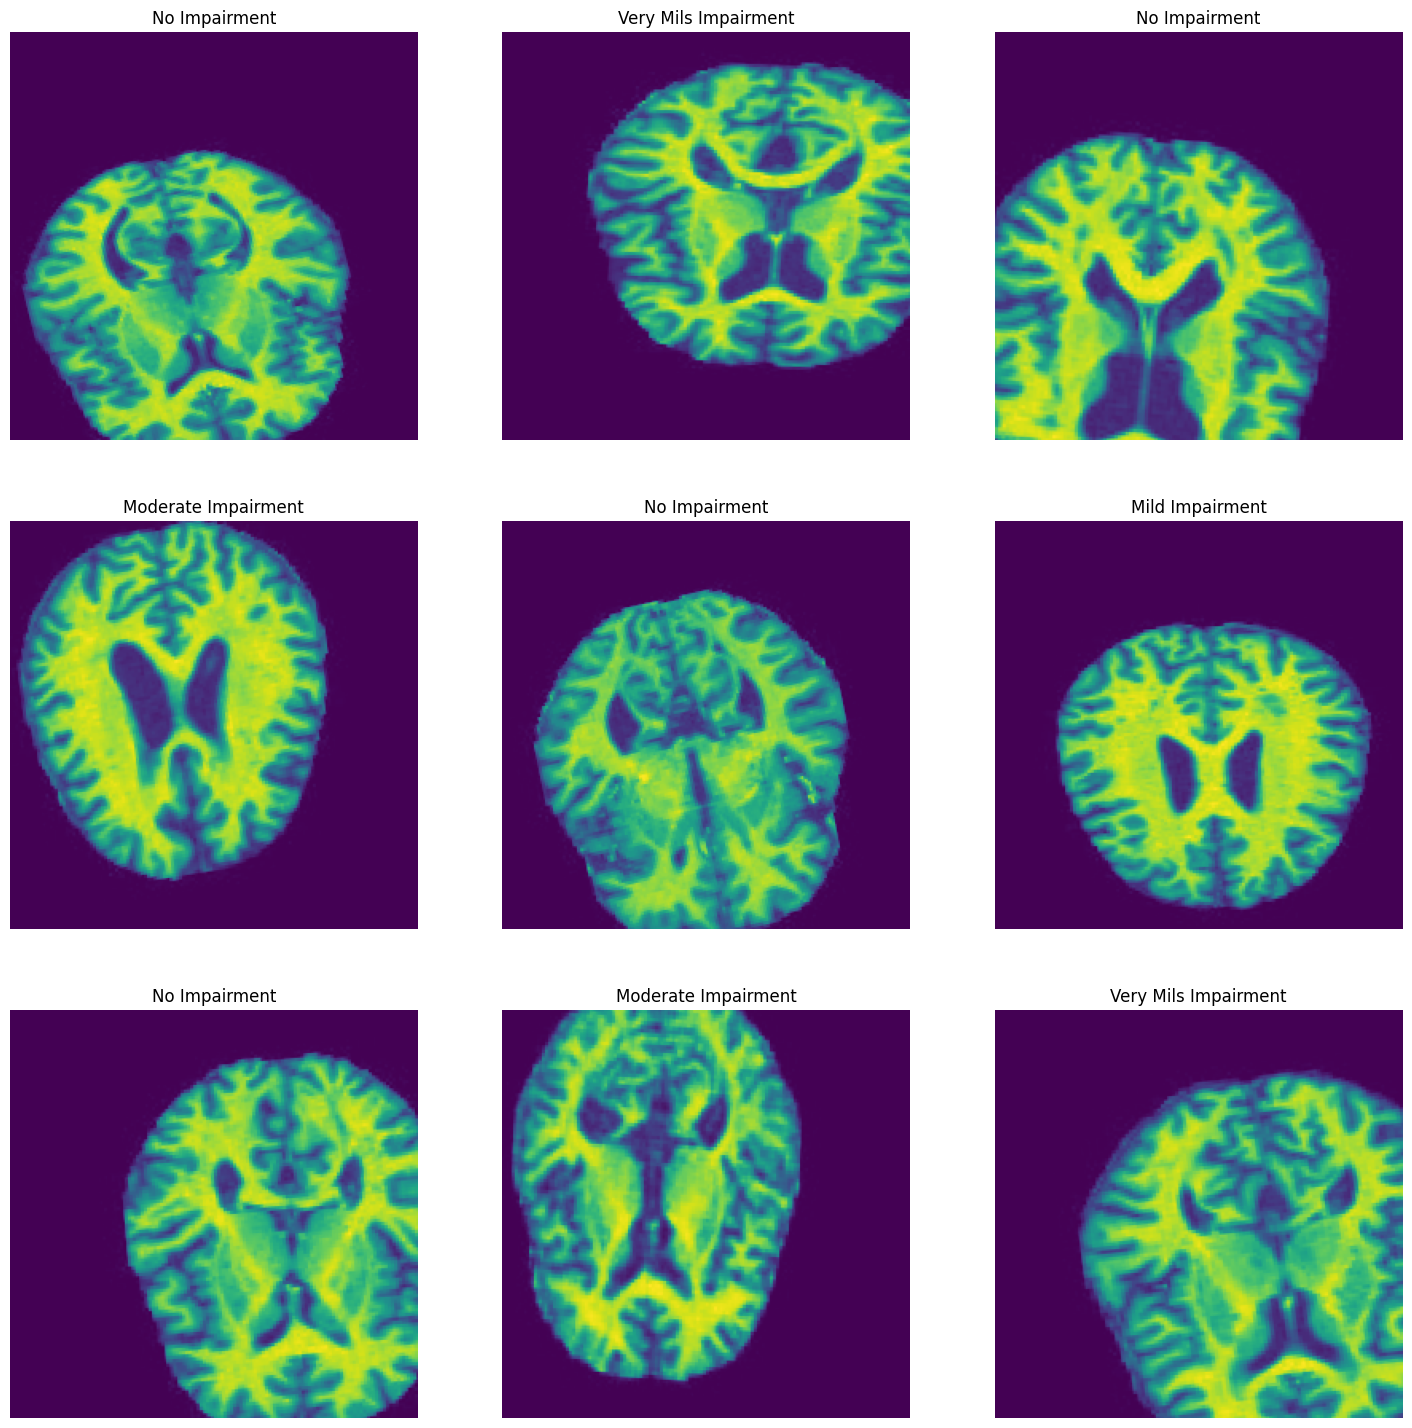

In [ ]:
# Melihat isi dataset
L = 3
W = 3

fig, axes = plt.subplots(L, W, figsize = (18,18))
axes = axes.ravel()

num_images = train_images.shape[0]
for i in np.arange(0, min(L * W, num_images)):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])+1])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.2)

Menampilkan Hasil Augmentasi Gambar

Found 11519 images belonging to 2 classes.
Found 11519 images belonging to 2 classes.
Found 11519 images belonging to 2 classes.
Found 11519 images belonging to 2 classes.
Found 11519 images belonging to 2 classes.


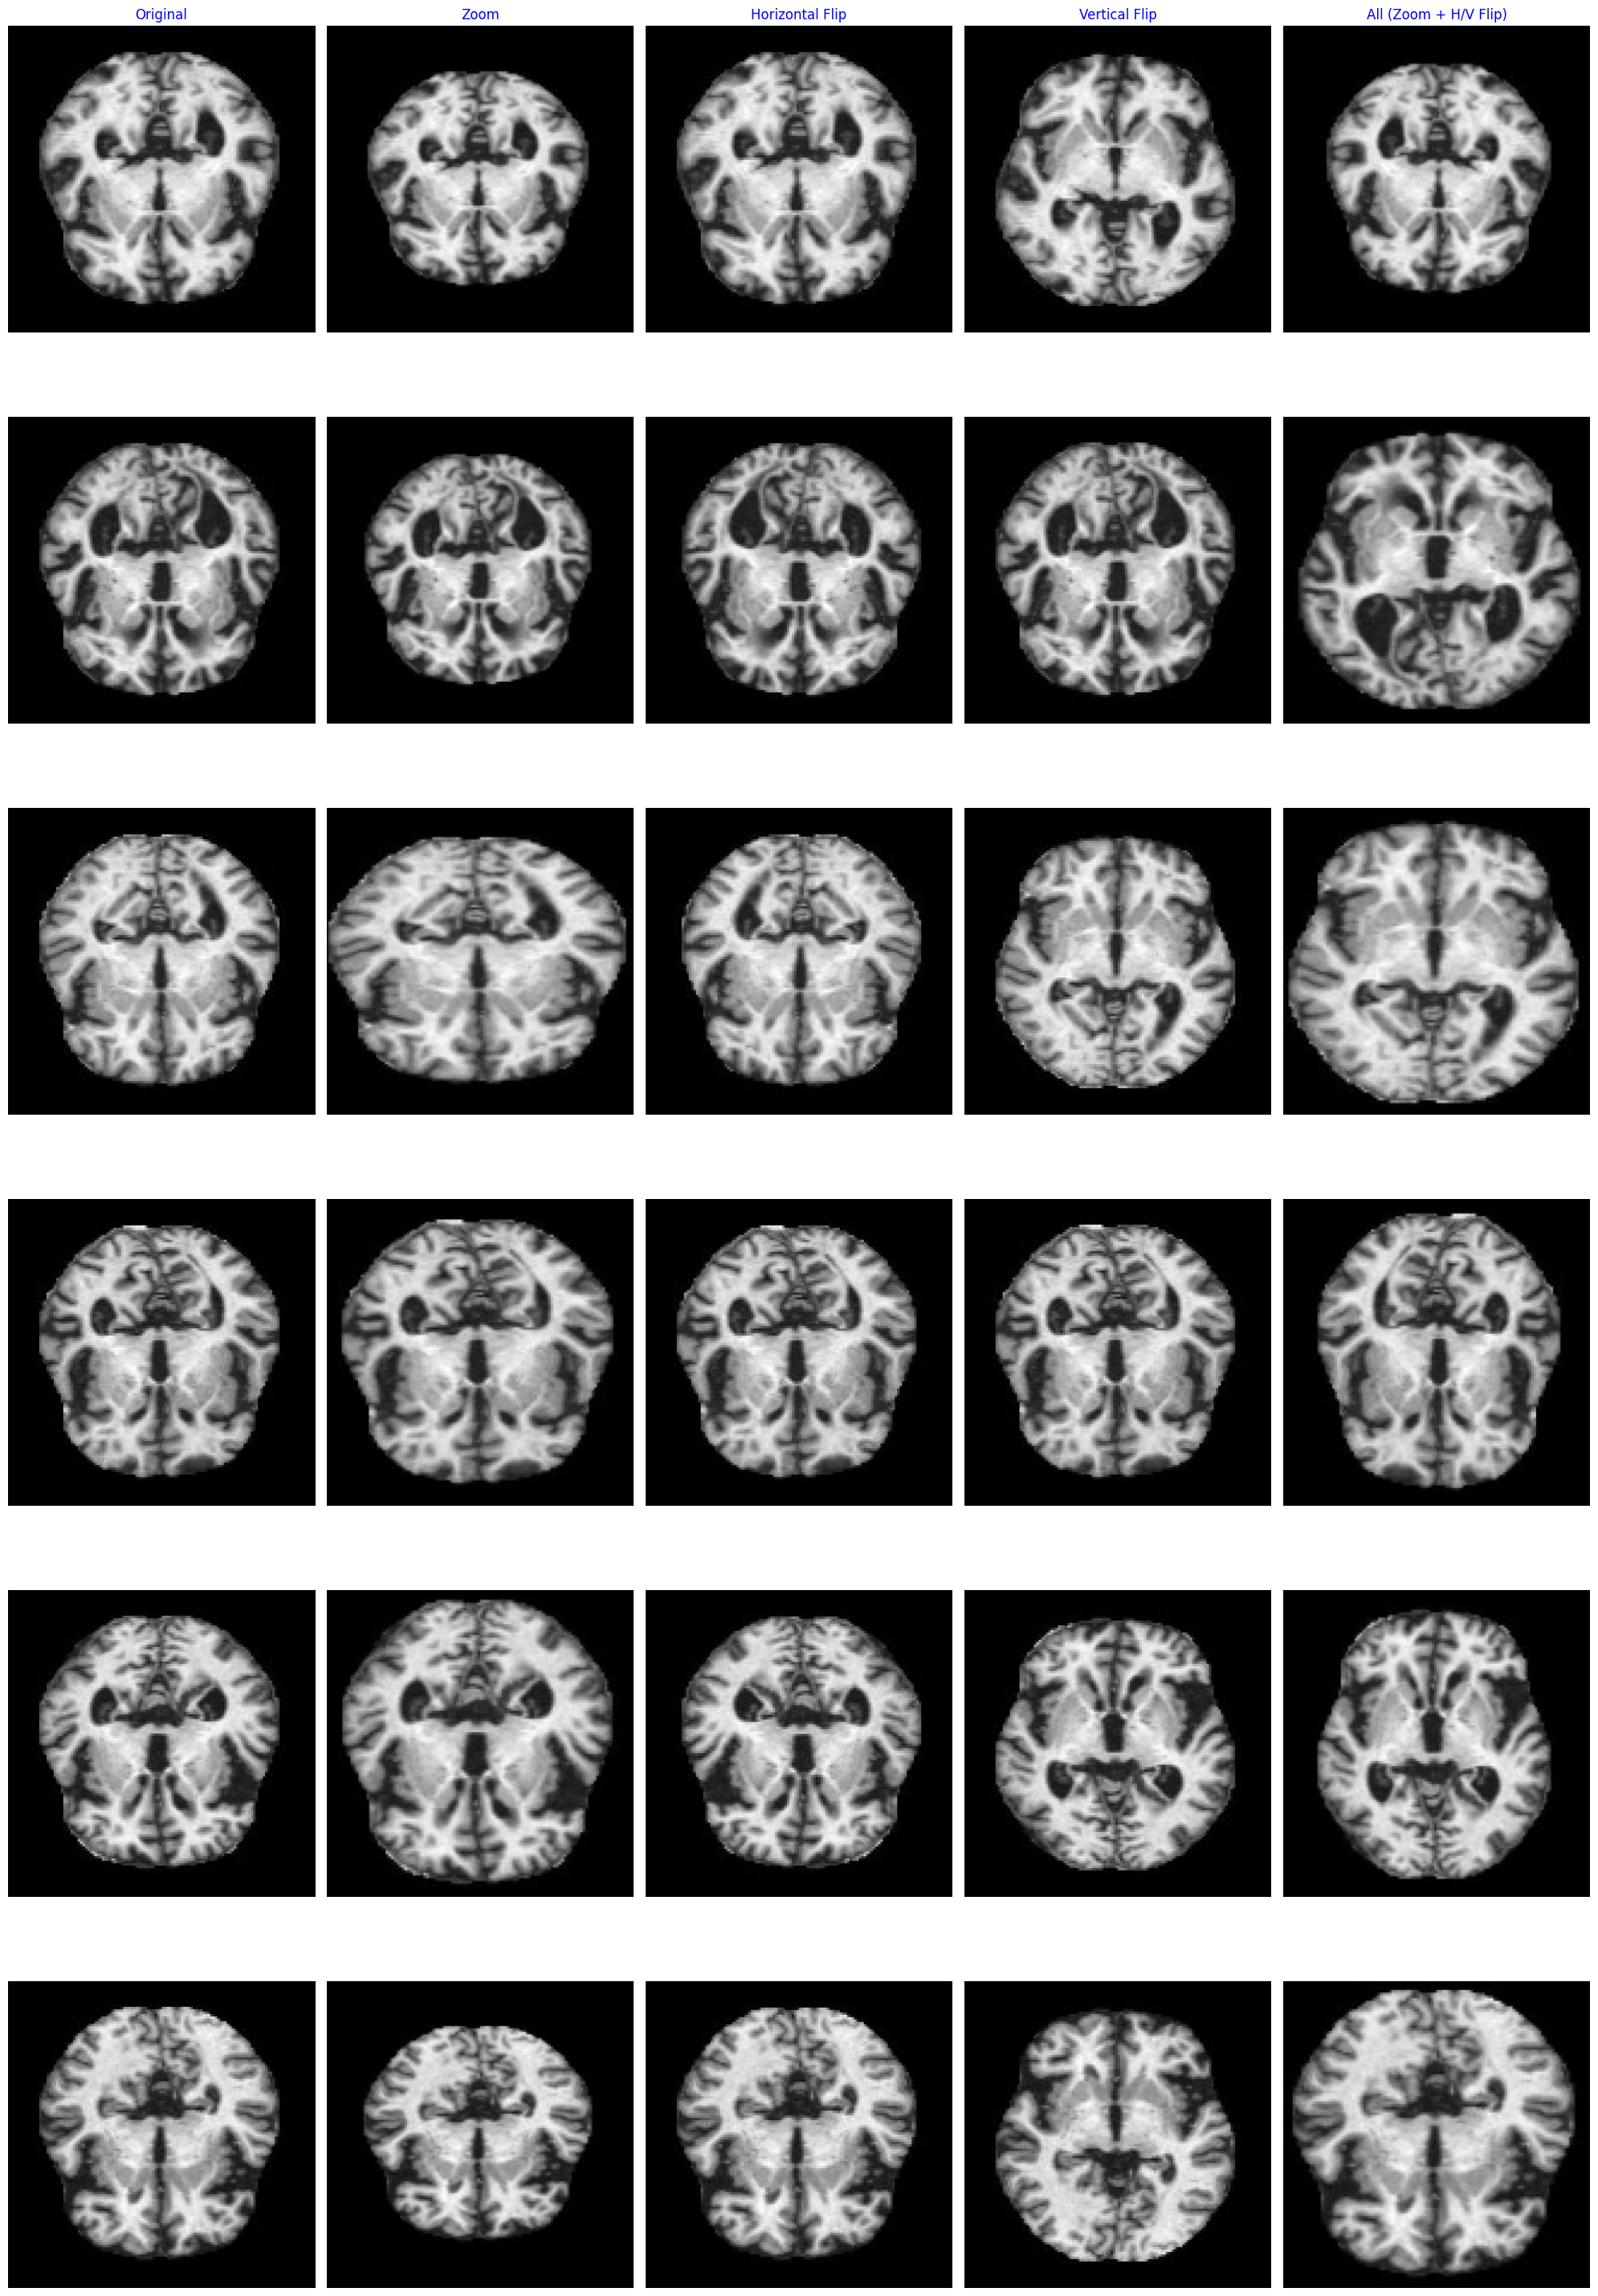

In [ ]:
def visualize_image_augmentation(X_Ray_Directory, batch_size=32, target_size=(256, 256), num_images=6):

# Buat ImageDataGenerator untuk setiap proses augmentasi secara terpisah
image_generators = {
        "Original": ImageDataGenerator(rescale=1.0/255),  # Hanya rescale
        "Zoom": ImageDataGenerator(rescale=1.0/255, zoom_range=0.2),  # Rescale + Zoom
        "Horizontal Flip": ImageDataGenerator(rescale=1.0/255, horizontal_flip=True),  # Rescale + H. Flip
        "Vertical Flip": ImageDataGenerator(rescale=1.0/255, vertical_flip=True),  # Rescale + V. Flip
        "All (Zoom + H/V Flip)": ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)  # Rescale + Zoom + Flip
    }

# Ambil batch dari setiap generator
image_batches = {}
    for key, generator in image_generators.items():
        data_flow = generator.flow_from_directory(
            batch_size=batch_size,
            directory=X_Ray_Directory,
            shuffle=False,
            target_size=target_size,
            class_mode='categorical',
            color_mode='grayscale'
        )
        images, _ = next(data_flow)  # Ambil satu batch gambar dari generator
        image_batches[key] = images

# Visualisasikan gambar dari setiap proses augmentasi
    plt.figure(figsize=(20, num_images * 5))

    for i in range(num_images):
        col_index = 1  # Indeks kolom awal untuk setiap baris
        for key, images in image_batches.items():
            ax = plt.subplot(num_images, len(image_generators), i * len(image_generators) + col_index)  # Indeks subplot
            plt.imshow(images[i].squeeze(), cmap='gray')  # Tampilkan gambar (squeeze untuk hapus dimensi ekstra)
            if i == 0:  # Hanya tampilkan judul di baris pertama
                plt.title(key, fontsize=12, color='blue')
            plt.axis("off")  # Hilangkan sumbu
            col_index += 1  # Pindah ke kolom berikutnya di baris yang sama

    plt.tight_layout()
    plt.show()

# Contoh penggunaan fungsi
visualize_image_augmentation(X_Ray_Directory, batch_size=32, target_size=(256, 256), num_images=6)  # Visualisasikan 6 gambar

Pembangunan Model CNN untuk Deteksi

In [ ]:
# Input layer
input_layer = Input(shape=(256, 256, 1))

# Block 1
x = Conv2D(64, (3, 3), padding='same')(input_layer)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 2
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 3
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 4
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output before the Dense layers
x = Flatten()(x) # Add this line to flatten the output

# Fully connected layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x) # Change the output layer to 4 neurons

# Definisikan model
model = Model(inputs=input_layer, outputs=output_layer)

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall'])

# Tampilkan ringkasan model
model.summary()

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,095,748 (4.18 MB)

 Trainable params: 1,095,748 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

Pelatihan Model CNN dengan Recall sebagai Metrik Evaluasi

In [ ]:
# Preprocessing Data
train_dir = '/content/Combined Dataset/train'  # Sesuaikan path dataset di Google Drive
test_dir = '/content/Combined Dataset/test'

datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi data

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Multi-kelas
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Multi-kelas
)

# Definisi Model
num_classes = train_generator.num_classes  # Ambil jumlah kelas dari dataset

model = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Sesuaikan dengan jumlah kelas
])

# Kompilasi Model (tanpa akurasi)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.Recall(name='recall')]  # Hanya menampilkan recall
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath='weights.keras', verbose=1, save_best_only=True)

# Training Model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=[lr_scheduler, early_stopping, checkpointer]
)

# Menampilkan Plot Loss, Recall, dan Learning Rate
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

# Loss dan Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Validation Loss')

# Recall dan Validation Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall'], label='Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall vs Validation Recall')

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 1.0691 - recall: 0.3885
Epoch 1: val_loss improved from inf to 0.82124, saving model to weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - loss: 1.0681 - recall: 0.3890 - val_loss: 0.8212 - val_recall: 0.4629 - learning_rate: 1.0000e-04
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4864 - recall: 0.7243
Epoch 2: val_loss improved from 0.82124 to 0.77211, saving model to weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - loss: 0.4864 - recall: 0.7243 - val_loss: 0.7721 - val_recall: 0.5403 - learning_rate: 1.0000e-04
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.4071 - recall: 0.7799
Epoch 3: val_loss improved from 0.77211 to 0.66604, saving model to weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - loss: 0.4071 - recall: 0.7799 - val_loss: 0.6660 - val_recall: 0.5919 - learning_rate: 1.0000e-04
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3709 - recall: 

Visualisasi Performa Model melalui Recall dan Loss

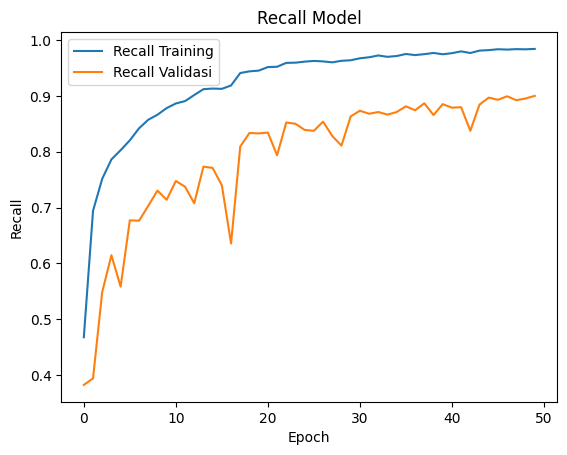

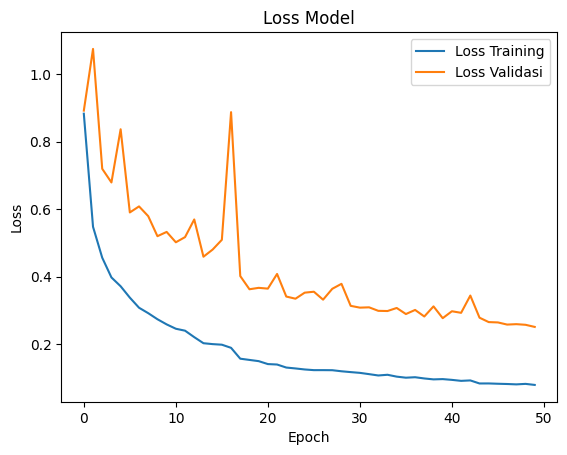

In [ ]:
plt.plot(history.history['recall'], label='Recall Training')
plt.plot(history.history['val_recall'], label='Recall Validasi')
plt.title('Recall Model')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Evaluasi Model CNN dengan Confusion Matrix dan Classification Report

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Model Loaded: /content/cnn_alzheimer_model.keras
📌 Model Input Shape: (None, 150, 150, 3)
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


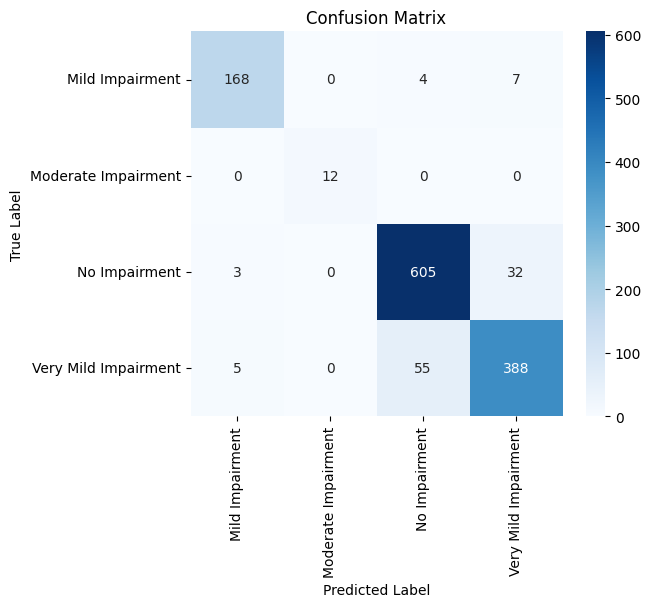

📌 Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.94      0.95       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.91      0.95      0.93       640
Very Mild Impairment       0.91      0.87      0.89       448

            accuracy                           0.92      1279
           macro avg       0.94      0.94      0.94      1279
        weighted avg       0.92      0.92      0.92      1279



In [ ]:
# Path ke Dataset
base_dir = '/content/Combined Dataset'  # Ganti dengan path dataset
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Tidak ada augmentasi untuk data test

# Load Data Train & Test
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', color_mode='rgb', shuffle=False
)

# Load Model yang Sudah Dilatih
model_path = '/content/cnn_alzheimer_model.keras'  # Ganti dengan path model Anda
model = load_model(model_path)
print(f"Model Loaded: {model_path}")
print(f"Model Input Shape: {model.input_shape}")

# Prediksi Data Test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluasi Model (Confusion Matrix & Classification Report)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Visualisasi Hasil Prediksi
def plot_predictions(images, true_labels, predicted_labels, class_names, n=9):
    n = min(n, len(images))  # Hindari IndexError jika jumlah gambar kurang
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPred: {predicted_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ambil batch pertama dari test_generator
test_images, _ = next(test_generator)

Visualisasi Prediksi Model CNN dengan Warna Indikasi Akurasi

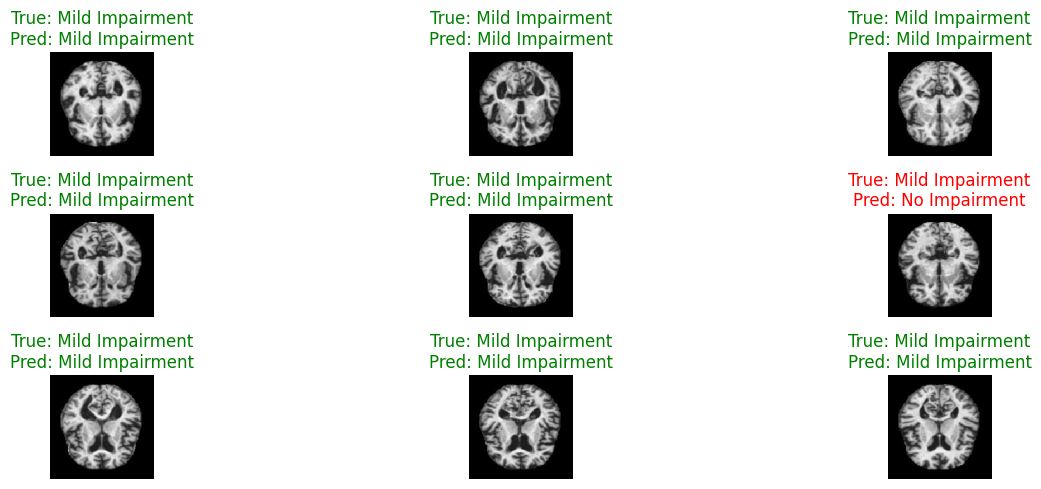

In [ ]:
# Visualisasi Hasil Prediksi
def plot_predictions(images, true_labels, predicted_labels, class_names, n=9):
    n = min(n, len(images))  # Hindari IndexError jika jumlah gambar kurang
    plt.figure(figsize=(15, 5))

    for i in range(n):
        plt.subplot(3, 3, i + 1)

        # Konversi gambar ke uint8 jika masih dalam format float
        img = (images[i] * 255).astype("uint8") if images[i].dtype == np.float32 else images[i]

        plt.imshow(img)

        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]

        # Warna hijau jika prediksi benar, merah jika salah
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPred: {predicted_label}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ambil batch pertama dari test_generator
test_images, test_labels = next(test_generator)  # Pastikan ada data yang diambil

# Pastikan test_images memiliki ukuran yang benar sebelum ditampilkan
if test_images.shape[0] > 0:
    plot_predictions(
        images=test_images[:9],
        true_labels=true_classes[:9],
        predicted_labels=predicted_classes[:9],
        class_names=class_labels,
        n=9
    )
else:
    print("❌ Tidak ada gambar yang tersedia dalam test_generator.")
